<a href="https://colab.research.google.com/github/Codenid/UTEC_2025_IA_FUNDAMENTALS/blob/main/TAREA/TAREA_2/Flow_Shop_Hill_Climbing_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajos vs Maquinas = Tiempos
[[20.54430295 24.17644888 12.87615892 18.45543657  8.52535166 12.69886516
   8.43475118 18.30214199 15.50792276 19.57422005]
 [13.56122138  4.74447332 16.09763371 18.88520779 12.85200051 15.98950157
  10.86615854 13.52857147 17.18008571 25.4487451 ]
 [15.3676213  27.91646081  9.54712302  4.18373231  8.420705   27.08573336
  13.64037998 14.20779742 13.65092993 17.21349791]
 [24.12353549 11.87167471 11.68358868 22.045415   17.863137   13.71332867
  13.01619896 13.91262139 22.64041578 25.81797573]
 [17.38705161 15.20922122 14.96700002 17.82158674 18.51539715 14.66864873
  14.34588154 10.4625898  14.20401124 12.24589782]
 [16.12290883 19.10107866 14.39108803 17.40060515 16.24743935  8.78015688
  17.17052029 21.68024169  8.93593663 20.51538339]
 [18.31868039 11.59268748 10.21433996 11.42419696 15.19177955 20.30599893
   9.82935417 19.96465871 21.92937041 12.14901617]
 [15.55347838 15.75076457 12.07854672 13.47148001 16.65407998 15.05625971
  12.5147587  21.179

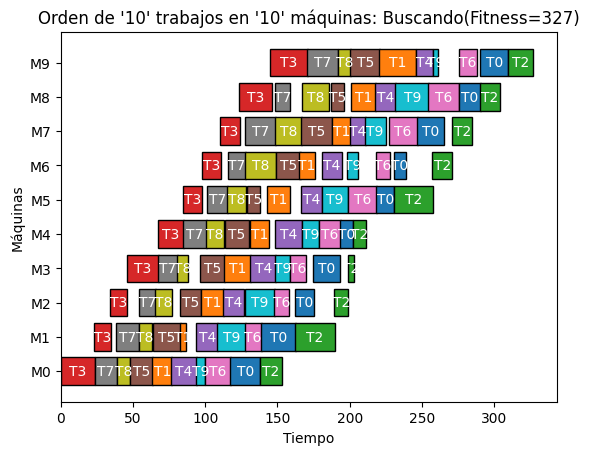

current_solution [3 7 8 5 1 4 9 6 0 2]
fitness current_solution 327

Iteration...


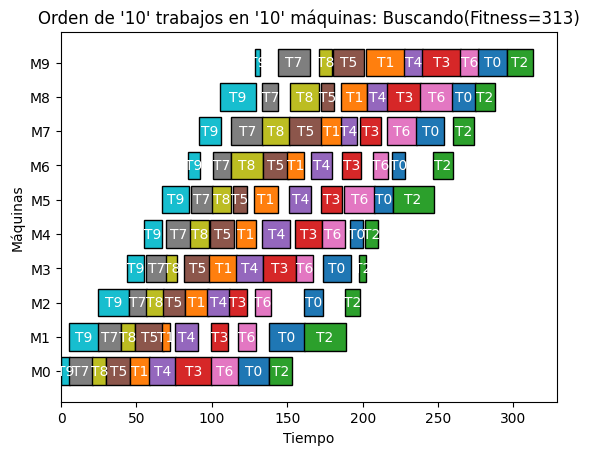

current_solution [9 7 8 5 1 4 3 6 0 2]
fitness current_solution 313

Iteration...


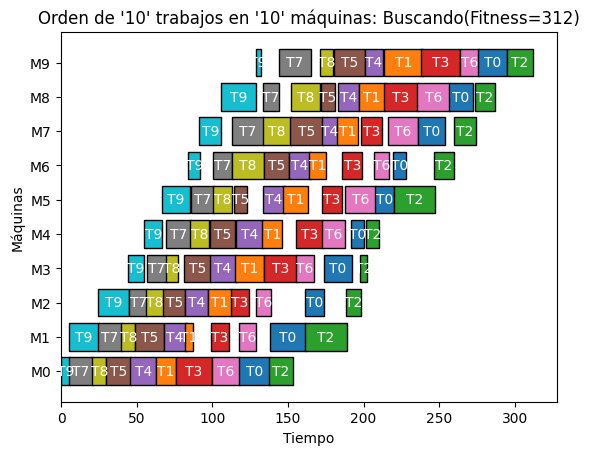

current_solution [9 7 8 5 4 1 3 6 0 2]
fitness current_solution 312

Iteration...


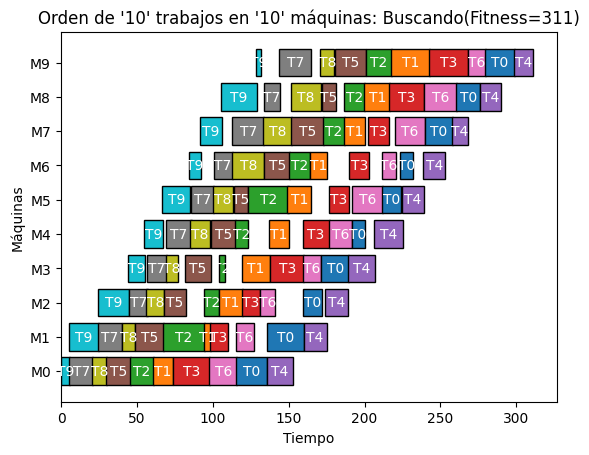

current_solution [9 7 8 5 2 1 3 6 0 4]
fitness current_solution 311

Iteration...


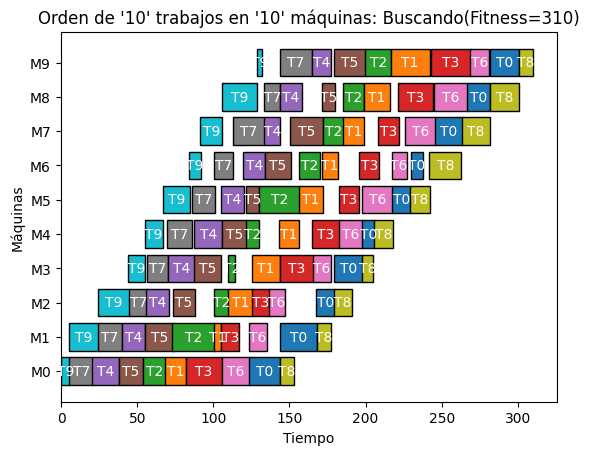

current_solution [9 7 4 5 2 1 3 6 0 8]
fitness current_solution 310

Iteration...


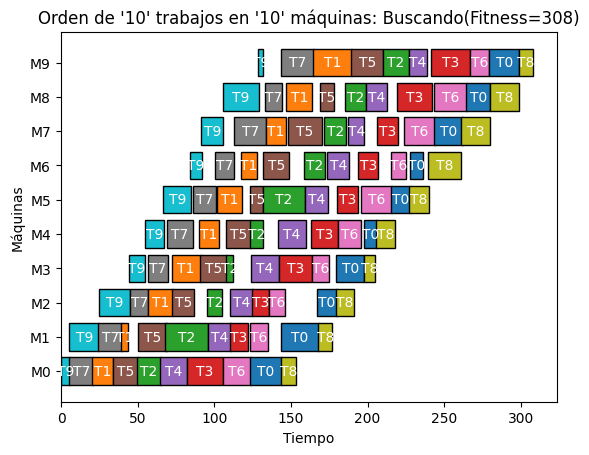

current_solution [9 7 1 5 2 4 3 6 0 8]
fitness current_solution 308

Iteration...


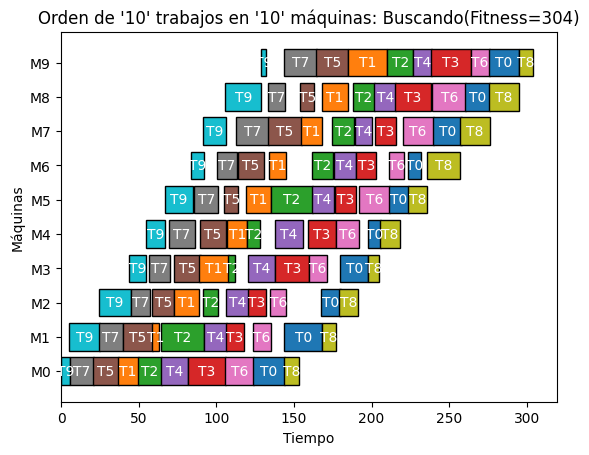

current_solution [9 7 5 1 2 4 3 6 0 8]
fitness current_solution 304


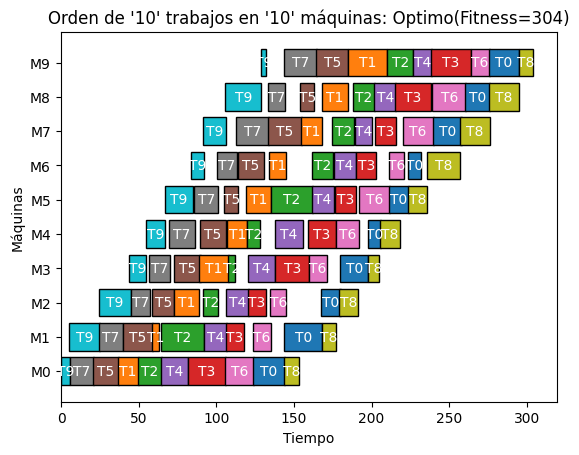

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Variables iniciales
#num_jobs = 2 # @param {type:"number"}
#num_machines = 10 # @param {type:"number"}

num_jobs = 10
num_machines = 10

def generar_matriz_aleatoria(num_filas, num_columnas, tiempo_prom=15, tiempo_desviacion=5):
    """
    Genera una matriz de tiempos de procesamiento aleatoria.

    Parámetros:
    - num_filas: número de trabajos (filas).
    - num_columnas: número de máquinas (columnas).
    - tiempo_min: valor mínimo del tiempo de procesamiento.
    - tiempo_max: valor máximo del tiempo de procesamiento.

    Retorna:
    - Matriz de tiempos de procesamiento aleatoria.
    """
    #matriz_tiempos = np.random.randint(tiempo_prom, tiempo_desviacion + 1, size=(num_filas, num_columnas))
    matriz_tiempos = np.random.normal(tiempo_prom, tiempo_desviacion, size=(num_filas, num_columnas))
    return matriz_tiempos

tiempos_procesamiento = generar_matriz_aleatoria(num_jobs, num_machines)
print("Trabajos vs Maquinas = Tiempos")
print(tiempos_procesamiento)

# Step 1
current_solution = np.arange(len(tiempos_procesamiento))
np.random.shuffle(current_solution)
print("\nSolución Inicial")
print(current_solution)

# Paso 2
def times_for_fitness(sol):
  # La primera fila nos da la cantidad de maquinas
  num_maquinas = len(tiempos_procesamiento[0])
  # Número de trabajos
  num_trabajos = len(sol)
  # Matríz para almancenar los tiempos de cama ejecución
  matriz_tiempos = np.zeros((num_trabajos, num_maquinas), dtype=int)

  for i, trabajo in enumerate(sol):
      for j in range(num_maquinas):
          if i == 0 and j == 0:
              matriz_tiempos[i][j] = tiempos_procesamiento[trabajo][j]
          elif i == 0:
              matriz_tiempos[i][j] = matriz_tiempos[i][j-1] + tiempos_procesamiento[trabajo][j]
          elif j == 0:
              matriz_tiempos[i][j] = matriz_tiempos[i-1][j] + tiempos_procesamiento[trabajo][j]
          else:
              matriz_tiempos[i][j] = max(matriz_tiempos[i-1][j], matriz_tiempos[i][j-1]) + tiempos_procesamiento[trabajo][j]
  return matriz_tiempos

def fitness(sol):
  tiempo_total_finalizacion = times_for_fitness(sol)[-1][-1]
  return tiempo_total_finalizacion

current_fitness = fitness(current_solution)
print("Fitness Inicial")
print( current_fitness )

# Paso 3
def get_neighbors(sol):
  neighbors = []
  for i in range(len(sol) - 1):
    for j in range( i + 1, len(sol) ):
      new_sol = sol.copy()
      new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
      neighbors.append(new_sol)
  return neighbors

#print( (current_solution) )
#print( get_neighbors(current_solution) )


# Paso 5
# Función para graficar el orden de tareas en las máquinas
def plot_schedule(sol, fitness, tipo):
    matriz_tiempos = times_for_fitness(sol)
    num_maquinas = len(tiempos_procesamiento[0])
    num_trabajos = len(sol)

    fig, ax = plt.subplots()

    for i, trabajo in enumerate(sol):
        for j in range(num_maquinas):
            inicio = matriz_tiempos[i][j] - tiempos_procesamiento[trabajo][j]
            duracion = tiempos_procesamiento[trabajo][j]
            ax.barh(j, duracion, left=inicio, color=f"C{trabajo}", edgecolor="black")
            ax.text(inicio + duracion / 2, j, f"T{trabajo}", va="center", ha="center", color="white")

    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Máquinas")
    ax.set_title(f"Orden de '{num_trabajos}' trabajos en '{num_maquinas}' máquinas: {tipo}(Fitness={fitness})")
    ax.set_yticks(range(num_maquinas))
    ax.set_yticklabels([f"M{j}" for j in range(num_maquinas)])

    plt.show()

# Paso 4
def hill_climbing(current_solution):
  print("")
  count = 0
  while True:

    print("Iteration...")
    # step: generar vecinos
    neighbors = get_neighbors(current_solution)
    best_neighbor = min(neighbors, key=fitness)
    best_fitness = fitness(current_solution)

    if count % 2 == 0:
      plot_schedule(current_solution, best_fitness, "Buscando")

    print("current_solution", current_solution)
    print("fitness current_solution", best_fitness)
    #print("neighbors", neighbors)
    #print("best_neighbor", best_neighbor)
    #print("fitness best_neighbor", fitness(best_neighbor))
    best_fitness_neighbor = fitness(best_neighbor)
    if best_fitness_neighbor < fitness(current_solution):
      current_solution = best_neighbor
      best_fitness = best_fitness_neighbor
    else:
      return current_solution, best_fitness

    print("")

solution, solution_fitness = hill_climbing(current_solution)


#plot_schedule(current_solution, current_fitness, "Inicial")
plot_schedule(solution, fitness(solution), "Optimo")